In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.layers import *

import tensorflow as tf

from keras import backend as K

## Network building blocks

In [2]:
def resnet_unit(feat_dim, kernel_size, x_in):
    # conv = Conv2D(feats, kernel, padding="same")
    res = keras.Sequential([
        Conv2D(feat_dim, kernel_size, padding="same"
               ,kernel_initializer='he_uniform'
               ,bias_initializer='he_uniform',
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
              ),
        ReLU(),
        Conv2D(feat_dim, kernel_size, padding="same", 
               kernel_initializer='he_uniform',
               bias_initializer='he_uniform',
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
    ])
    return ReLU()(x_in + res(x_in))

def resnet_block(feat_dim, reps, x_in, pooling = True):
    # Stage 2
    conv1 = Conv2D(feat_dim, 3, padding="same", kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x_in)
    relu1 = ReLU()(conv1)
    conv2 = Conv2D(feat_dim, 3, padding="same", kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(relu1)
    x = ReLU()(conv2)
    for _ in range(reps):
        x = resnet_unit(feat_dim,3,x)
    if pooling == True:
        x = MaxPooling2D(2,2)(x)
        return x
    else:
        return x

class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(filters, 3, padding="same", activation="relu",kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same",kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
        self.conv_beta = layers.Conv2D(filters, 3, padding="same",kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]

    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(raw_mask, self.resize_shape, method="nearest")
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta
        return output

def spade_generator_unit(feats_in, feats_out, kernel, x, mask, upsampling = True):
    x = GaussianNoise(0.05)(x)
    # SPADE & conv
    spade1 = SPADE(feats_in)(x, mask)
    conv1 = Conv2D(feats_in,kernel, padding='same', activation= LeakyReLU(0.2),kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(spade1)
   
    conv_out = Conv2D(feats_out,kernel, padding='same', kernel_initializer='he_uniform',
               bias_initializer='he_uniform',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(conv1)
    output = LeakyReLU(0.2)(conv_out)
    if upsampling == True:
        output = UpSampling2D(size = (2,2))(output)
        return output
    else:
        return output

def resnet_based_encoder(latent_dims = 512, input_shape = (224,448,1)):
    inputs = keras.Input(shape = input_shape)
    x = Conv2D(64, 7, padding="same", activation = 'relu', kernel_initializer='he_uniform',
               bias_initializer='he_uniform', 
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(inputs)
    x = MaxPooling2D(2,2)(x)
    x1 = resnet_block(64,1,x,pooling = True)
    x2 = resnet_block(128,2,x1,pooling = True)
    x3 = resnet_block(256,2,x2,pooling = True)
    
    x3 = Conv2D(64, 1, padding="same", kernel_initializer='he_uniform',
               bias_initializer='he_uniform',
               kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                activity_regularizer=regularizers.L1(1e-4))(x3)
    encoder = keras.Model(inputs, x3)
    return encoder
# resnet_based_encoder().summary()

def spade_based_generator(output_activation = 'linear'):
    latent_input = keras.Input(shape = (14,28,64))
    latent_input = GaussianNoise(0.1)(latent_input)
    sp_bl_init = Conv2D(256, 3, padding="same", activation= LeakyReLU(0.2),
                        kernel_initializer='he_uniform', bias_initializer='he_uniform',
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(latent_input)
    sp_bl2 = spade_generator_unit(256,128,3,sp_bl_init,latent_input, upsampling = True)
    sp_bl3 = spade_generator_unit(128,64,3,sp_bl2,latent_input, upsampling = True)
    sp_bl4 = spade_generator_unit(64,64,3,sp_bl3,latent_input, upsampling = True)
    sp_bl5 = spade_generator_unit(64,64,3,sp_bl4,latent_input, upsampling = True)
    if output_activation == 'sigmoid':
        recon = Conv2D(1,3,padding="same",activation = 'sigmoid', kernel_initializer='he_uniform',
               bias_initializer='he_uniform',
                   kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) )(sp_bl5)
        print('sigmoid')
    else:
        recon = Conv2D(1,3,padding="same",kernel_initializer='he_uniform',
               bias_initializer='he_uniform',
                   kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) )(sp_bl5)

    decoder = keras.Model(latent_input, recon)
    return decoder
# spade_based_generator().summary()

def latent_evolution_model():
    latent_input = keras.Input(shape = (14,28,64))
    conv1 = Conv2D(64, 1, padding = 'same', activation = LeakyReLU(0.2), kernel_initializer='he_uniform',
               bias_initializer='he_uniform', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(latent_input)
    bn1 = BatchNormalization()(conv1)
    relu1 = LeakyReLU(0.2)(bn1)
    conv2 = Conv2D(64, 1, padding = 'same', activation = LeakyReLU(0.2), kernel_initializer='he_uniform',
               bias_initializer='he_uniform', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(conv1)
    bn2 = BatchNormalization()(conv2)
    relu2 = LeakyReLU(0.2)(bn2)
    conv3 = Conv2D(64, 1, padding = 'same', kernel_initializer='he_uniform',
               bias_initializer='he_uniform', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(conv2)
    latent_out = keras.Model(latent_input, conv3)
    return latent_out

## Model library

### Physics-informed autoencoder without latent evolution

In [3]:
class PILR(keras.Model):
    def __init__(self, **kwargs):
        super(PILR, self).__init__(**kwargs)
        self.encoder = resnet_based_encoder()
        self.decoder = spade_based_generator(output_activation = 'sigmoid')

        # loss define
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        total_loss = 0
        with tf.GradientTape() as tape:
            # AE loss
            latent_micro = self.encoder(data)
            recon_micro = self.decoder(latent_micro)
            total_loss = tf.keras.losses.BinaryCrossentropy()(data,recon_micro)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
        }

### Physics-informed autoencoder with latent evolution

In [4]:
class PILE(keras.Model):
    def __init__(self, **kwargs):
        super(PILE, self).__init__(**kwargs)
        self.encoder = resnet_based_encoder()
        self.decoder = spade_based_generator()
        self.latent_evolution = latent_evolution_model()
        # loss define
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.in_ae_loss_tracker = keras.metrics.Mean(name="in_ae_loss")
        self.out_ae_loss_tracker = keras.metrics.Mean(name="out_ae_loss")
        self.latent_loss_tracker = keras.metrics.Mean(name="latent_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")

    @property
    def metrics(self):
        return [
        self.total_loss_tracker,
        self.in_ae_loss_tracker,
        self.out_ae_loss_tracker,
        self.latent_loss_tracker,
        self.recon_loss_tracker
        ]

    def train_step(self, data):

        input_temp = data[0]
        output_temp = data[1]
        total_loss = 0
        with tf.GradientTape() as tape:
            # AE loss
            latent_temp_in = self.encoder(input_temp)
            ae_recon_temp_in = self.decoder(latent_temp_in)
            in_ae_loss = tf.keras.losses.MeanSquaredError()(input_temp,ae_recon_temp_in)
            latent_temp_out = self.encoder(output_temp)
            ae_recon_temp_out = self.decoder(latent_temp_out)
            out_ae_loss = tf.keras.losses.MeanSquaredError()(output_temp,ae_recon_temp_out)

            ae_loss = in_ae_loss + out_ae_loss

            pred_latent_temp_out = self.latent_evolution(latent_temp_in, latent_temp_out)
            latent_loss = tf.keras.losses.MeanSquaredError()(pred_latent_temp_out,latent_temp_out)
            recon_latent_temp = self.decoder(pred_latent_temp_out)
            recon_loss = tf.keras.losses.MeanSquaredError()(output_temp,recon_latent_temp)
            

            total_loss =  recon_loss + ae_loss + latent_loss
            
        self.total_loss_tracker.update_state(total_loss)
        self.in_ae_loss_tracker.update_state(in_ae_loss)
        self.out_ae_loss_tracker.update_state(out_ae_loss)
        self.latent_loss_tracker.update_state(latent_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))


        return {
            "total_loss": self.total_loss_tracker.result(),
            "in_ae_loss": self.in_ae_loss_tracker.result(),
            "out_ae_loss": self.out_ae_loss_tracker.result(),
            "latent_loss": self.latent_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
        }

# Learning microstructure latent representation

### Load data

In [ ]:
input_micro = []
micro_data = np.load('micro_data.npy')
for i in range(45):
    for j in range(1):
        input_micro.append(micro_data[i,:,:,:])
input_micro = np.array(input_micro)       
print(input_micro.shape)

### Traing model

In [32]:
model_micro = PILR()
# model_micro.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00001,beta_1=0.9,beta_2=0.99))
# model_micro.fit(input_micro, batch_size = 4, epochs = 1000, shuffle = True)
model_micro.encoder.load_weights('micro_enc_new.h5')
model_micro.decoder.load_weights('micro_dec_new.h5')

sigmoid


### Test

In [ ]:
for idx in range(45,51):
    z4 = model_micro.encoder(micro_data[idx:idx+1,:,:,:])
    recon_micro = model_micro.decoder(z4)
    plt.imshow(np.squeeze(z4[:,:,:,i]), cmap = 'gray', vmin = 0, vmax= 1)
    plt.show()
    plt.imshow(np.squeeze(micro_data[idx:idx+1,:,:,:]), cmap = 'gray', vmin = 0, vmax= 1)
    plt.show()

# Learning temperature latent representation

## Load data

In [ ]:
# data.shape
data = np.load('temp_data.npy')

temp_data_in = []
temp_data_out = []
# micro_data_train = []
for i in range(45):
    for j in range (23):
        temp_data_in.append(data[i,:,:,j:j+1])
        temp_data_out.append(data[i,:,:,j+1:j+2])

#         micro_data_train.append(micro_data[i:i+1,:,:,j:j+1])
temp_in = np.array(temp_data_in)
temp_out = np.array(temp_data_out)
print(temp_in.shape)
print(temp_out.shape)
# temp_train = np.array(temp_data_train)
# # micro_train = np.array(micro_data_train)
# print(temp_train.shape)

In [ ]:
# model_temp = PILE()
# model_temp.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.99))
# model_temp.fit(temp_in, temp_out, batch_size = 4, epochs =100, shuffle = True)

model_temp.encoder.save_weights('temp_enc_28_56.h5')
model_temp.decoder.save_weights('temp_dec_28_56.h5')
model_temp.latent_evolution.save_weights('temp_pile_28_56.h5')

### Test model

In [ ]:
model_temp = PILE()
model_temp.encoder.load_weights('temp_enc_28_56.h5')
model_temp.decoder.load_weights('temp_dec_28_56.h5')
model_temp.latent_evolution.load_weights('temp_pile_28_56.h5')

In [ ]:
# data = np.load('temp_data.npy')
# # data.shape
# temp_data_in_test = []
# temp_data_out_test = []
# # micro_data_train = []
# for i in range(45,51):
#     for j in range (21):
#         temp_data_in_test.append(data[i,:,:,j:j+1])
#         temp_data_out_test.append(data[i,:,:,j+1:j+2])

# #         micro_data_train.append(micro_data[i:i+1,:,:,j:j+1])
# temp_in_test = np.array(temp_data_in_test)
# temp_out_test = np.array(temp_data_out_test)
# print(temp_in_test.shape)


output = []
gt = []

for i in range(70,75):
    # AE loss
    latent_temp = model_temp.encoder(temp_in_test[i:i+1,:,:,:])
#     for _ in range(1):
#         next_latent = model_temp.latent_evolution(latent_temp)
#         latent_temp = next_latent

#     recon_tempField = model_temp.decoder(latent_temp)
    output.append(latent_temp)
#     gt.append(temp_out_test[i:i+1,:,:,:])
# gt_next_latent = model_temp.encoder(gt_field_out[:,:,:,:])
# gt_latent.append(gt_next_latent)
# print(output[0].shape)
# fig,ax = plt.subplots(2,5, figsize = (20,4))

# for j in range(5):
#     ax[0][j].imshow(np.squeeze(output[j]), cmap = 'jet', vmin = 0, vmax = 1)
#     ax[1][j].imshow(np.squeeze(gt[j]), cmap = 'jet', vmin = 0, vmax = 1)
# plt.show()

# fig,ax = plt.subplots(8,8, figsize = (16,8))
# for j in range(8):
#     ax[0][j].imshow(np.squeeze(output[0][:,:,:,j]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[1][j].imshow(np.squeeze(output[0][:,:,:,j+7]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[2][j].imshow(np.squeeze(output[0][:,:,:,j+15]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[3][j].imshow(np.squeeze(output[0][:,:,:,j+23]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[4][j].imshow(np.squeeze(output[0][:,:,:,j+31]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[5][j].imshow(np.squeeze(output[0][:,:,:,j+39]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[6][j].imshow(np.squeeze(output[0][:,:,:,j+47]), cmap = 'gray')#, vmin = -1, vmax = 1)
#     ax[7][j].imshow(np.squeeze(output[0][:,:,:,j+55]), cmap = 'gray')#, vmin = -1, vmax = 1)
# plt.show()

# plt.imshow(temp_in_test[40,:,:,:], cmap = 'jet', vmin = 0 , vmax = 1)
# plt.show()

# np.amin(next_latent[:,:,:,:])
idx = 15
print(np.amax(output[0][:,:,:,idx]))
print(np.amin(output[0][:,:,:,idx]))
# output[0].shape



# Latent PARC

## Transform data to latent

In [5]:
temp_mapping = PILE()
temp_mapping.encoder.load_weights('temp_enc_28_56.h5')
temp_mapping.encoder.trainable = False
temp_mapping.decoder.load_weights('temp_dec_28_56.h5')
temp_mapping.decoder.trainable = False
temp_mapping.latent_evolution.load_weights('temp_pile_28_56.h5')
temp_mapping.latent_evolution.trainable = False

micro_mapping = PILR()
micro_mapping.encoder.load_weights('micro_enc_new.h5')
micro_mapping.encoder.trainable = False
micro_mapping.decoder.trainable = False

sigmoid


In [7]:
# # Microstructure
micro_data = np.load('micro_data.npy')
latent_micro = np.array(micro_mapping.encoder(micro_data))
# for feats in range(16):
#     max_val = np.amax(latent_micro[:,:,:,feats])
#     min_val = np.amin(latent_micro[:,:,:,feats])
#     latent_micro[:,:,:,feats:feats+1] = (latent_micro[:,:,:,feats:feats+1] - min_val)/(max_val-min_val)
# latent_micro = np.expand_dims(latent_micro, -1)
# print(latent_micro.shape)

# for feats in range(16):
#     plt.imshow(np.squeeze(zt_micro[0,:,:,feats]), vmin = 0, vmax = 1)# Normalize data in latent space
#     plt.show()


# Temperature
data = np.load('temp_data.npy')

latent_temp = []
for ts in range(24):
    zt = temp_mapping.encoder(data[:,:,:,ts])
    latent_temp.append(zt)
latent_temp = np.array(latent_temp)
print(latent_temp.shape)
latent_temp = np.moveaxis(latent_temp,0,-1)

# print(latent_temp.shape)
# max_val_whole = []
# min_val_whole = []
# for feats in range(64):
#     max_val = np.amax(latent_temp[:,:,:,feats,:])
#     max_val_whole.append(max_val)
#     min_val = np.amin(latent_temp[:,:,:,feats,:])
#     min_val_whole.append(min_val)
#     latent_temp[:,:,:,feats,:] = (latent_temp[:,:,:,feats,:] - min_val)/(max_val-min_val)

# for ts in range(24):
#     plt.imshow(np.squeeze(latent_temp[0,:,:,15,ts]), vmin = 0, vmax = 1)# Normalize data in latent space
#     plt.show()

(24, 52, 14, 28, 64)


In [8]:
def latent_physics():
    z_m = keras.Input(shape = (14,28,64))
    z_t = keras.Input(shape = (14,28,64))
    
#     concat = Concatenate()([z_m,z_t])
    z_m_noise = GaussianNoise(0.05)(z_m)  
    z_t_noise = GaussianNoise(0.05)(z_t)  

    # spade block
    sp_bl = spade_generator_unit(64,128,3,z_t_noise,z_m_noise, upsampling = False)

    conv11 = Conv2D(128,1, activation = ELU(), padding = 'same')(sp_bl)
    conv21 = Conv2D(128,1, activation = ELU(), padding = 'same')(sp_bl)
    conv21 = Conv2D(128,3, activation = ELU(), padding = 'same')(conv21)
    conv31 = Conv2D(128,1, activation = ELU(), padding = 'same')(sp_bl)
    conv31 = Conv2D(128,5, activation = ELU(), padding = 'same')(conv31)

    incept1 = Concatenate()([Concatenate()([conv11,conv21]),conv31])
    conv_out1 = Conv2D(256,1, activation = LeakyReLU(0.2), padding = 'same')(incept1)
    conv_out2 = Conv2D(512,1, activation = LeakyReLU(0.2), padding = 'same')(conv_out1)
    conv_out3 = Conv2D(1024,1, activation = LeakyReLU(0.2), padding = 'same')(conv_out2)
    
    conv_out = Conv2D(64, 1, padding = 'same', kernel_initializer = 'he_normal')(conv_out3)

#     out = z_t + conv_out
#     spade1 = SPADE(16)(conv2, z_m_base)
#     conv3 = Conv2D(16,3, padding='same', activation= LeakyReLU(0.2),kernel_initializer='he_uniform',
#                bias_initializer='he_uniform')(spade1)
  
    latent_out = keras.Model([z_m, z_t], conv_out)
    return latent_out
# latent_physics().summary()

### Model definition

In [9]:
class LatentPARC(keras.Model):
    def __init__(self, ts, **kwargs):
        super(LatentPARC, self).__init__(**kwargs)
        
        self.latent_physics = latent_physics()
#         self.latent_physics.load_weights('latent_parc_strong_recurrent.h5')
#         self.shape_descriptor = shape_descriptor() 
#         self.shape_descriptor.load_weights('latent_parc_shape_descriptor.h5')
        # loss define
        self.mapping = PILE()
        self.mapping.encoder.load_weights('temp_enc_28_56.h5')
        self.mapping.encoder.trainable = False
        self.mapping.decoder.load_weights('temp_dec_28_56.h5')
        self.mapping.decoder.trainable = False
        self.mapping.latent_evolution.load_weights('temp_pile_28_56.h5')
        self.mapping.latent_evolution.trainable = False
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")      
        self.ts = ts

        self.latent_loss_tracker = keras.metrics.Mean(name="latent_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.latent_loss_tracker,
            self.recon_loss_tracker
        ]

    def train_step(self, data):
        init_temp = data[0][0]
        micro = data[0][1]
        temp_gt = data[1][0]
        temp = data[1][1]
        latent_loss = 0
        recon_loss = 0
        with tf.GradientTape() as tape:
#             shape_descriptor = self.shape_descriptor(micro)
            latent_current = init_temp
            for i in range(self.ts):
                latent_next = self.latent_physics([micro,latent_current])
                latent_current = latent_next
    #                 latent_gt = tf.squeeze(temp_gt[:,:,:,:,i])
                iter_latent_loss = tf.keras.losses.MeanSquaredError()(latent_next,temp_gt[:,:,:,:,i])
                recon = self.mapping.decoder(latent_next)
                iter_recon_loss = tf.keras.losses.MeanSquaredError()(recon,temp[:,:,:,i])
                
                latent_loss += iter_latent_loss
                recon_loss += iter_recon_loss

            total_loss = 0.7*recon_loss + 0.3*latent_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.latent_loss_tracker.update_state(latent_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "latent_loss": self.latent_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
        }

In [19]:
input_micro = []
for i in range(45):
    for j in range(14):
        input_micro.append(latent_micro[i,:,:,:])
input_micro = np.array(input_micro)       
print(input_micro.shape)

(630, 14, 28, 64)


In [20]:
# data.shape
temp_data_in = []
temp_data_out = []
temp = []
# micro_data_train = []
for i in range(45):
    for j in range (14):
        temp_data_in.append(latent_temp[i,:,:,:,j:j+1])
        temp_data_out.append(latent_temp[i,:,:,:,j+1:j+11])
        temp.append(data[i,:,:,j+1:j+11])
#         micro_data_train.append(micro_data[i:i+1,:,:,j:j+1])
temp_in = np.array(temp_data_in)
temp_out = np.array(temp_data_out)
temp = np.array(temp)

print(temp_in.shape)
print(temp_out.shape)
print(temp.shape)

# temp_train = np.array(temp_data_train)
# # micro_train = np.array(micro_data_train)
# print(temp_train.shape)

(630, 14, 28, 64, 1)
(630, 14, 28, 64, 10)
(630, 224, 448, 10)


In [ ]:
parc = LatentPARC(ts = 1)
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)

In [16]:
parc.latent_physics.save_weights('latent_parc_strong_recurrent.h5')
# parc.shape_descriptor.save_weights('latent_parc_shape_descriptor_strong_recurrent.h5')

In [ ]:
parc = LatentPARC(ts = 2)
parc.latent_physics.load_weights('latent_parc_strong_recurrent.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_2.h5')

In [ ]:
parc = LatentPARC(ts = 3)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_2.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_3.h5')

In [ ]:
parc = LatentPARC(ts = 4)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_3.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_4.h5')

In [ ]:
parc = LatentPARC(ts = 5)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_4.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_5.h5')

In [40]:
# parc = LatentPARC(ts = 6)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_8.h5')
# parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
# parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
# parc.latent_physics.save_weights('latent_parc_strong_recurrent_6.h5')

In [ ]:
parc = LatentPARC(ts = 7)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_6.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 100, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_7.h5')

In [ ]:
parc = LatentPARC(ts = 8)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_7.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
parc.fit([temp_in,input_micro],[temp_out,temp], batch_size = 4, epochs = 20, shuffle = True)
parc.latent_physics.save_weights('latent_parc_strong_recurrent_8.h5')

In [36]:
parc = LatentPARC(ts = 10)
parc.latent_physics.load_weights('latent_parc_strong_recurrent_6.h5')

(7, 14, 28, 64)
(7, 14, 28, 64, 22)
(7, 14, 28, 64, 22)
(7, 224, 448, 22)


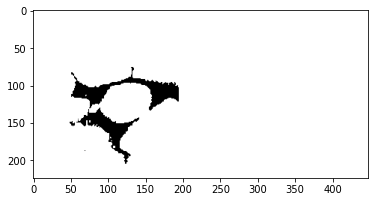

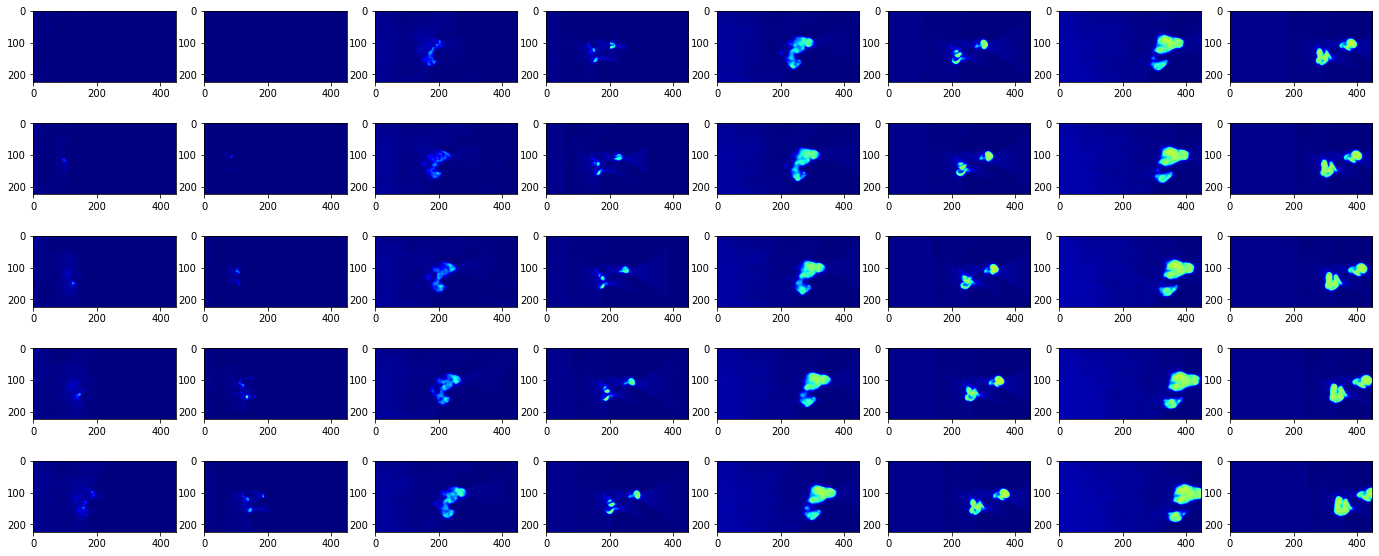

In [40]:
data = np.load('temp_data.npy')
micro_data = np.load('micro_data.npy')

input_micro_test = []
for i in range(45,52):
    for j in range(1):
        input_micro_test.append(latent_micro[i,:,:,:])
input_micro_test = np.array(input_micro_test)      
# input_micro_test = np.expand_dims(input_micro_test, -1)
print(input_micro_test.shape)

temp_data_in_test = []
temp_data_out_test = []
temp_test = []
for i in range(45,52):
    for j in range (1):
        temp_data_in_test.append(latent_temp[i,:,:,:,j+1])
        temp_data_out_test.append(latent_temp[i,:,:,:,j+1:j+23])
        temp_test.append(data[i,:,:,j+1:j+23])

temp_data_in_test = np.array(temp_data_in_test)
temp_data_out_test = np.array(temp_data_out_test)
temp_test = np.array(temp_test)
print(temp_data_out_test.shape)
print(temp_data_out_test.shape)
print(temp_test.shape)


idx = 3

zt_current = temp_data_in_test[idx:idx+1,:,:,:]
zm = input_micro_test[idx:idx+1,:,:,:]

output = []
gt = []
for i in range(20):
#     zt_next = parc.latent_physics([zm,zt_current])
    zt_next = parc.latent_physics([zm,zt_current])
    zt_current = zt_next

    recon = parc.mapping.decoder(zt_next)
    output.append(np.array(recon))

    gt.append(temp_test[idx:idx+1,:,:,i])

# output[0].shape
# ts = 0
# fig,ax = plt.subplots(4,8, figsize = (40,10))
# for j in range(4):
#     ax[j][0].imshow(np.squeeze(output[ts][:,:,:,j]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][1].imshow(np.squeeze(gt[ts][:,:,:,j]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][2].imshow(np.squeeze(output[ts][:,:,:,j+4]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][3].imshow(np.squeeze(gt[ts][:,:,:,j+4]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][4].imshow(np.squeeze(output[ts][:,:,:,j+8]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][5].imshow(np.squeeze(gt[ts][:,:,:,j+8]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][6].imshow(np.squeeze(output[ts][:,:,:,j+12]), cmap = 'jet')#, vmin = 0, vmax = 1)
#     ax[j][7].imshow(np.squeeze(gt[ts][:,:,:,j+12]), cmap = 'jet')#, vmin = 0, vmax = 1)
    
    
# for i in range(20):
#     print('ts ',i)
#     plt.imshow(np.squeeze(output[i]), cmap = 'jet', vmin = 0, vmax = 1)
#     plt.show()
#     plt.imshow(np.squeeze(gt[i]), cmap = 'jet', vmin = 0, vmax = 1)
#     plt.show()
    
# print(output[i].shape)
# for feats in range(64):
# #     print('Mode ', feats+1)
#     max_val = max_val_whole[feats]
#     min_val = min_val_whole[feats]
#     for i in range(22):
#         output[i][:,:,:,feats:feats+1] = output[i][:,:,:,feats:feats+1]*(max_val-min_val) + min_val

# temp = []
# for i in range(22):
#     recon = temp_mapping.decoder(output[i])
#     temp.append(recon)
plt.imshow(np.squeeze(micro_data[idx+45,:,:,:]), cmap = 'gray', vmin = 0, vmax = 1)
plt.show()

fig,ax = plt.subplots(5,8, figsize = (24,10))
for j in range(5):
    ax[j][0].imshow(np.squeeze(output[j]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][1].imshow(np.squeeze(gt[j]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][2].imshow(np.squeeze(output[j+5]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][3].imshow(np.squeeze(gt[j+5]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][4].imshow(np.squeeze(output[j+10]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][5].imshow(np.squeeze(gt[j+10]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][6].imshow(np.squeeze(output[j+15]), cmap = 'jet', vmin = 0, vmax = 1)
    ax[j][7].imshow(np.squeeze(gt[j+15]), cmap = 'jet', vmin = 0, vmax = 1)
plt.show()


In [31]:
len(max_val_whole)

16

In [ ]:
output = []
# latent_temp_current = input_test[0]

# for i in range(23):
        latent_temp_next = parc.latent_diff([input_data[0][5:6,:,:,:], input_data[1][5:6,:,:,:]])
        temp_recon = void_collapse_latent_space.latent_mapping.temp_decoder(latent_temp_next)

        output.append(temp_recon)
        latent_temp_current = latent_temp_next



In [ ]:
plt.imshow(np.squeeze(input_test[1][:,:,:,3]))

In [ ]:
for i in range(16):
    plt.imshow(np.squeeze(output[i][:,:,:,0]), cmap= 'jet')#, vmin=0,vmax=1)
    plt.show()

In [ ]:
def latent_evo_low_res():
    z_m = keras.Input(shape = (7,14,512))
    z_t = keras.Input(shape = (7,14,512))

    concat = Concatenate()([z_m,z_t])
    conv1 = Conv2D(512, 3, activation='relu', padding = 'same')(concat)
    conv2 = Conv2D(512, 3, activation='relu', padding = 'same')(conv1)
    conv3 = Conv2D(512, 3, activation='relu', padding = 'same')(conv2)

    latent_out = keras.Model([z_m, z_t], conv3)
    return latent_out
# style_gan_based_generator().summary()

def latent_evo_high_res():
    z_m = keras.Input(shape = (28,56,128))
    z_t = keras.Input(shape = (28,56,128))

    concat = Concatenate()([z_m,z_t])
    conv1 = Conv2D(128, 5, activation='relu', padding = 'same')(concat)
    conv2 = Conv2D(128, 5, activation='relu', padding = 'same')(conv1)
    conv3 = Conv2D(128, 5, activation='relu', padding = 'same')(conv2)

    latent_out = keras.Model([z_m, z_t], conv3)
    return latent_out
# style_gan_based_generator().summary()

In [ ]:
class latentPARC(keras.Model):
    def __init__(self, ts, **kwargs):
        super(latentPARC, self).__init__(**kwargs)
        self.t_AE = temp_AE()
        self.t_AE.encoder.load_weights('temp_enc_with_noise.h5')
        self.t_AE.encoder.trainable = False
        self.t_AE.decoder.load_weights('temp_dec_new.h5')
        self.t_AE.decoder.trainable = False

        self.m_AE = micro_AE()
        self.m_AE.encoder.load_weights('micro_enc.h5')
        self.m_AE.encoder.trainable = False
        self.m_AE.decoder.trainable = False
        
        self.lat_evo_high_res = latent_evo_high_res()
        self.lat_evo_high_res.load_weights('high_res_lat_evo.h5')

        self.lat_evo_low_res = latent_evo_low_res()
        self.lat_evo_low_res.load_weights('low_res_lat_evo.h5')

        # loss define
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.latent_loss_tracker = keras.metrics.Mean(name="latent_loss")
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        
        self.ts = ts

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.latent_loss_tracker,
            self.recon_loss_tracker
        ]

    def train_step(self, data):
        batch = data[0][0].get_shape()[0]
        init_temp = data[0][0]
        micro = data[0][1]
        temp_gt = data[1]
        recon_loss = 0
        latent_loss = 0
        ae_loss = 0
        with tf.GradientTape(persistent = True) as tape:
            for i in range(self.ts):
                if i != 0:
                    iter_latent_loss, iter_recon_loss, iter_ae_loss, recon_temp = self.recurrent_func(current_temp, micro, temp_gt[:,:,:,i:i+1])
                else:
                    current_temp = init_temp
                    iter_latent_loss, iter_recon_loss, iter_ae_loss, recon_temp = self.recurrent_func(current_temp, micro, temp_gt[:,:,:,i:i+1])
                    
                latent_loss += iter_latent_loss
                recon_loss += iter_recon_loss
                ae_loss += iter_ae_loss
                current_temp = recon_temp
            total_loss = latent_loss + recon_loss
#             total_loss_2 = total_loss + ae_loss
#             total_loss_temp_ae = 0.0005*total_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
#         grads_2 = tape.gradient(total_loss_2, self.lat_evo_low_res.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads_2, self.lat_evo_low_res.trainable_weights))
        
#         grads_3 = tape.gradient(total_loss_temp_ae, self.t_AE.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads_3, self.t_AE.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.latent_loss_tracker.update_state(latent_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "latent_loss": self.latent_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
        }
    
    def recurrent_func(self, current_temp, in_micro, temp_gt):
        
        _,zt2,_,zt4 = self.t_AE.encoder(current_temp)
        zm2,zm4 = self.m_AE.encoder(in_micro)

        zt_out_high = self.lat_evo_high_res([zm2,zt2])
        zt_out_low = self.lat_evo_low_res([zm4,zt4])

        _,zt2_gt,_,zt4_gt = self.t_AE.encoder(temp_gt)

        iter_latent_loss = tf.keras.losses.MeanAbsoluteError()(zt_out_high,zt2_gt) + tf.keras.losses.MeanAbsoluteError()(zt_out_low,zt4_gt)
        recon_temp = self.t_AE.decoder([zt_out_high,zt_out_low])
        iter_recon_loss = tf.keras.losses.BinaryCrossentropy()(temp_gt,recon_temp)
        
        recon_gt = self.t_AE.decoder([zt2_gt,zt4_gt])
        iter_ae_loss = tf.keras.losses.BinaryCrossentropy()(temp_gt,recon_gt)

        return iter_latent_loss, iter_recon_loss, iter_ae_loss, recon_temp

In [ ]:
parc = latentPARC(ts = 12)
parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.9,beta_2=0.99))
parc.fit([temp_in,input_micro],temp_out, batch_size = 4, epochs = 35, shuffle = True)


In [ ]:
print(temp_in.shape)
print(input_micro.shape)

In [ ]:
print(temp_out.shape)

In [ ]:
# parc.t_AE.decoder.save_weights('temp_dec_new.h5')
parc.lat_evo_high_res.save_weights('high_res_lat_evo_1.h5')
parc.lat_evo_low_res.save_weights('low_res_lat_evo_1.h5')

In [ ]:
# data = np.load('temp_data.npy')

# temp_test_in_list = []
# temp_test_out_list = []
# micro_test_list = []

# for i in range(41,51):
#     for j in range (22):
#         temp_test_in_list.append(data[i,:,:,j:j+1])
#         temp_test_out_list.append(data[i,:,:,j+1:j+2])
#         micro_test_list.append(micro_data[i,:,:,:])
        
# temp_test_in = np.array(temp_test_in_list)
# temp_test_out = np.array(temp_test_out_list)
# micro_test = np.array(micro_test_list)
# print(temp_test_out.shape)

idx = 46
output = []
_,zt2,_,zt4 = parc.t_AE.encoder(data[idx:idx+1,:,:,0:1])

for i in range(20):
    # AE loss
    zm2,zm4 = parc.m_AE.encoder(micro_data[idx:idx+1,:,:,:])
    zt_out_high = parc.lat_evo_high_res([zm2,zt2])
    zt_out_low = parc.lat_evo_low_res([zm4,zt4])

    recon_temp = parc.t_AE.decoder([zt_out_high,zt_out_low])
    
    _,zt2,_,zt4 = parc.t_AE.encoder(recon_temp)
    output.append(recon_temp)
    
for i in range(20):
    print("Time step ", i)
    plt.imshow(np.squeeze(output[i]), cmap = 'jet', vmin = 0, vmax = 1)
    plt.show()
    plt.imshow(np.squeeze(data[idx:idx+1,:,:,i+1]), cmap = 'jet', vmin = 0, vmax = 1)
    plt.show()

In [ ]:
# recon_temp = data[idx:idx+1,:,:,15:16]
_,zt2,_,zt4 = parc.t_encoder(recon_temp)
zm2,zm4 = parc.m_encoder(micro_data[idx:idx+1,:,:,:])
zt_out_high = parc.lat_evo_high_res([zm2,zt2])
zt_out_low = parc.lat_evo_low_res([zm4,zt4])

recon_temp = parc.t_decoder([zt_out_high,zt_out_low])
plt.imshow(np.squeeze(recon_temp))

In [ ]:
plt.imshow(np.squeeze(data[idx:idx+1,:,:,20:21]))